# INR (JAX) Viewer: Load Saved Weights and Compare

Load saved Fourier-feature INR parameters, run prediction on selected cases, and visualize overlays with per-slice metrics. No training/JIT heavy steps to reduce memory pressure.

In [ ]:
import os, math, pathlib, json
import numpy as np
import nibabel as nib
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import List, Tuple

DATA_ROOT = pathlib.Path('../data/BraTS-2023')
WEIGHTS_PATH = pathlib.Path('../artifacts/inr_siren_brats23.npz')
FOURIER_FREQS = 16
NUM_CLASSES = 4

MODALITY_SUFFIXES = ['t1n', 't1c', 't2w', 't2f']
SEG_SUFFIX = 'seg'

def find_cases(root: pathlib.Path):
    cases = []
    for p in sorted(root.iterdir()):
        if p.is_dir():
            if any((p / f'{p.name}-{m}.nii.gz').exists() for m in MODALITY_SUFFIXES):
                cases.append(p)
    return cases

def load_case(case_dir: pathlib.Path):
    base = case_dir.name
    mods = []
    for suf in MODALITY_SUFFIXES:
        fp = case_dir / f'{base}-{suf}.nii.gz'
        arr = nib.load(str(fp)).get_fdata().astype(np.float32)
        m = arr != 0
        if m.any():
            mu = arr[m].mean(); sigma = arr[m].std() + 1e-6
            arr = (arr - mu) / sigma
        mods.append(arr)
    seg = nib.load(str(case_dir / f'{base}-{SEG_SUFFIX}.nii.gz')).get_fdata().astype(np.int16)
    return np.stack(mods, axis=0), seg

def fourier_features(coords: jnp.ndarray, k: int) -> jnp.ndarray:
    B, dim = coords.shape
    freqs = jnp.arange(1, k+1)
    ang = coords[..., None] * freqs[None, None, :] * math.pi
    ff = jnp.concatenate([jnp.sin(ang), jnp.cos(ang)], axis=-1).reshape(B, dim*2*k)
    return ff

def build_input(coords, intensities):
    ff = fourier_features(coords, FOURIER_FREQS)
    return jnp.concatenate([coords, ff, intensities], axis=-1)

def apply_mlp(params, x):
    *hidden, last = params
    h = x
    for layer in hidden:
        h = jnp.dot(h, layer['W']) + layer['b']
        h = jax.nn.relu(h)
    return jnp.dot(h, last['W']) + last['b']

def load_params_npz(path: pathlib.Path):
    d = np.load(path)
    layers = []
    i = 0
    while f'W_{i}' in d:
        layers.append({'W': jnp.array(d[f'W_{i}']), 'b': jnp.array(d[f'b_{i}'])})
        i += 1
    return layers

def predict_volume(params, mods, seg_true, chunk=120000):
    M, H, W, D = mods.shape
    xs, ys, zs = np.arange(H), np.arange(W), np.arange(D)
    grid = np.stack(np.meshgrid(xs, ys, zs, indexing='ij'), axis=-1).reshape(-1,3)
    intens = mods.transpose(1,2,3,0).reshape(-1, M)
    norm_coords = (grid / np.array([H-1, W-1, D-1])) * 2.0 - 1.0
    preds = []
    for i in range(0, len(grid), chunk):
        x_in = build_input(jnp.array(norm_coords[i:i+chunk]), jnp.array(intens[i:i+chunk]))
        cls = jnp.argmax(apply_mlp(params, x_in), axis=-1)
        preds.append(np.array(cls, dtype=np.int16))
    pred = np.concatenate(preds, axis=0).reshape(H, W, D)
    return pred, seg_true

def dice_score(pred, true, num_classes=4):
    out = {}
    for c in range(num_classes):
        p = pred==c; t = true==c
        inter = (p & t).sum(); denom = p.sum()+t.sum()
        out[c] = float((2*inter + 1e-6)/(denom + 1e-6)) if denom>0 else np.nan
    return out


## Load Weights and Evaluate

Loaded params: 5
Inferred FOURIER_FREQS = 4
Dice: {0: 0.9976912206552094, 1: 0.1622188906175248, 2: 0.17799878223710172, 3: 0.8538495786842034}


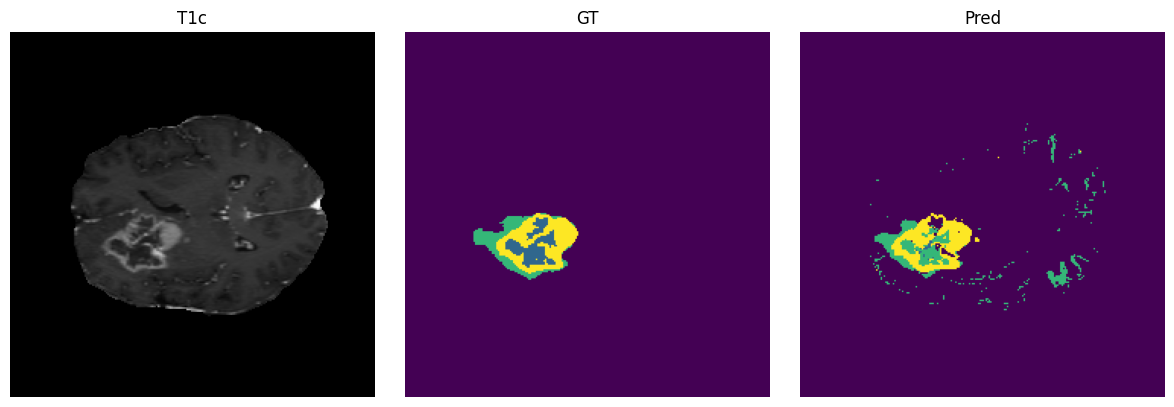

In [2]:
params = load_params_npz(WEIGHTS_PATH)
print('Loaded params:', len(params))
cases = find_cases(DATA_ROOT)
mods, seg = load_case(cases[0])
# Infer FOURIER_FREQS from checkpoint and modalities if possible
n_in = int(params[0]['W'].shape[0])
M = mods.shape[0]
rem = n_in - 3 - M
if rem % 6 == 0 and rem > 0:
    FOURIER_FREQS = int(rem // 6)
    print('Inferred FOURIER_FREQS =', FOURIER_FREQS)
else:
    print('Could not infer FOURIER_FREQS from weights; using default', FOURIER_FREQS)
pred, true = predict_volume(params, mods, seg)
print('Dice:', dice_score(pred, true))
mid = pred.shape[2]//2
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('T1c'); plt.imshow(mods[1,:,:,mid], cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title('GT'); plt.imshow(true[:,:,mid], vmin=0, vmax=3); plt.axis('off')
plt.subplot(1,3,3); plt.title('Pred'); plt.imshow(pred[:,:,mid], vmin=0, vmax=3); plt.axis('off')
plt.tight_layout(); plt.show()


In [3]:
import numpy as _np
def _dice_macro_slice(pred2d, true2d, num_classes=4):
    scores=[]
    for c in range(num_classes):
        p=(pred2d==c); t=(true2d==c)
        inter=(p & t).sum(); denom=p.sum()+t.sum()
        if denom>0: scores.append((2*inter+1e-6)/(denom+1e-6))
    return float(_np.mean(scores)) if scores else float('nan')
def _psnr_slice(pred2d, true2d, max_val=3.0):
    mse=_np.mean((_np.asarray(pred2d)-_np.asarray(true2d))**2)
    return float('inf') if mse<=1e-12 else float(10*_np.log10((max_val*max_val)/(mse+1e-12)))
def visualize_modalities_with_overlays(mods, seg_gt, seg_pred, z):
    M=mods.shape[0]
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, M, figsize=(3*M,6))
    if M==1: axes=_np.array([[axes[0]],[axes[1]]], dtype=object)
    for m in range(M):
        ax_gt=axes[0,m]; ax_pred=axes[1,m]
        ax_gt.imshow(mods[m,:,:,z], cmap='gray'); ax_gt.imshow(seg_gt[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3); ax_gt.set_title(f'Mod {m} + GT', fontsize=10); ax_gt.axis('off')
        ax_pred.imshow(mods[m,:,:,z], cmap='gray'); ax_pred.imshow(seg_pred[:,:,z], cmap='tab10', alpha=0.35, vmin=0, vmax=3);
        d=_dice_macro_slice(seg_pred[:,:,z], seg_gt[:,:,z]); p=_psnr_slice(seg_pred[:,:,z], seg_gt[:,:,z]); ax_pred.set_title(f'Mod {m} + Pred', fontsize=10);
        ax_pred.text(0.01,0.99,f'Dice {d:.3f} PSNR {p:.2f} dB', transform=ax_pred.transAxes, ha='left', va='top', fontsize=8, color='yellow', bbox=dict(boxstyle='round', fc='black', alpha=0.5, pad=0.4)); ax_pred.axis('off')
    fig.tight_layout(); plt.show()


## Interactive Hold-Out Viewer
Select a hold-out case and browse slices.

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
all_cases = find_cases(DATA_ROOT)
assert len(all_cases)>0, 'No cases found'
# Use cases after index 0 as hold-outs (or all)
holdouts = all_cases[1:] if len(all_cases)>1 else all_cases
case_opts = [(p.name, str(p)) for p in holdouts]
print('Hold-outs:', len(case_opts))
pred_cache = {}
state={'mods':None,'true':None,'pred':None}
def compute_prediction(case_path_str):
    if case_path_str in pred_cache: return pred_cache[case_path_str]
    p=pathlib.Path(case_path_str); mods, seg = load_case(p); pred,_= predict_volume(params, mods, seg); pred_cache[case_path_str]=(mods, seg, pred); return pred_cache[case_path_str]
out = widgets.Output()
if len(case_opts)==0:
    print('No hold-out cases to visualize.')
else:
    dd = widgets.Dropdown(options=case_opts, description='Case:')
    mods, true, pred = compute_prediction(dd.value); state['mods']=mods; state['true']=true; state['pred']=pred
    z_slider = widgets.IntSlider(min=0, max=int(pred.shape[2]-1), value=int(pred.shape[2]//2), description='Slice z')
    def render(z):
        with out:
            clear_output(wait=True)
            visualize_modalities_with_overlays(state['mods'], state['true'], state['pred'], int(z))
    def on_z(change): render(change['new'])
    def on_case(change):
        mods, true, pred = compute_prediction(change['new']); state['mods']=mods; state['true']=true; state['pred']=pred; z_slider.max=int(pred.shape[2]-1); z_slider.value=int(pred.shape[2]//2); render(z_slider.value)
    z_slider.observe(on_z, names='value'); dd.observe(on_case, names='value'); display(widgets.VBox([dd, z_slider, out])); render(z_slider.value)


Hold-outs: 1250
